# Exploratory study on existing early warning systems

## * Setup of the working environment *

### Import traditional Python packages

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime as dt, timedelta, date

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import time
import math
import json
import sys
import os

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Import custom Python modules

In [4]:
sys.path.append(os.path.abspath(os.path.join('..')))

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from helpers.db_connector import MySQLConnector
from helpers.db_query import *

from helpers.data_process import *
from helpers.feature_extraction import *

from extractors.akpinar_et_al import AkpinarEtAl
from extractors.boroujeni_et_al import BoroujeniEtAl
from extractors.chen_cui import ChenCui
from extractors.he_et_al import HeEtAl
from extractors.lalle_conati import LalleConati
from extractors.lemay_doleck import LemayDoleck
from extractors.mbouzao_et_al import MbouzaoEtAl
from extractors.mubarak_et_al import MubarakEtAl
from extractors.wan_et_al import WanEtAl

from helpers.ml_utils import *

from helpers.time import *

## * Load the clickstream data *

Since Fall 2017, the stream of the EPFL's Linear Algebra course has been taught in a flipped format. The implementation of the flipped classroom was carried out in an incremental manner, as described below:

- **Year 2017-2018**: traditional manner (weeks 1-13) - flipped manner (week 14).
- **Year 2018-2019**: traditional manner (weeks 1-4, 10-14) - flipped manner (weeks 5-9).
- **Year 2019-2020**: traditional manner (weeks 1-4) - flipped manner (weeks 5-14).

In [7]:
rounds = ['Y2-2018-19', 'Y3-2019-20']

### Identifying Students


The flipped course was offered only to volunteering students. The volunteers were collectively assigned into either the experimental and the control group. A stratified random sampling based on gender and the prior background (secondary educational level) of students were used.

In [8]:
%time userData = getUserInfo(prior_knowledge=True)

CPU times: user 54.3 s, sys: 2.36 s, total: 56.6 s
Wall time: 1min 30s


Given that the Y1-2017-2018 round included only one week in a flipped classroom setting, we will remove the students of that round.  

In [9]:
userData = userData[userData['Round'].isin(rounds)]

Some of the statistics on the user data are provided below. 

In [10]:
"Number of students:", len(userData)

('Number of students:', 214)

### Getting Students' Records

#### Exam Records

In [11]:
%time examData = getExamInfo()

CPU times: user 52.3 s, sys: 1.93 s, total: 54.3 s
Wall time: 1min 17s


In [12]:
examData = examData[examData['Round'].isin(rounds)]

In [13]:
examData = examData[examData['AccountUserID'].isin(userData['AccountUserID'])]

In [14]:
"Number of graded students:", len(examData)

('Number of graded students:', 214)

## * Cross validation of early warning systems *

#### Parameters

In [15]:
mode = 'random'
task = 'binary'
ratio = 80
start, end, step = 5, 15, 1
iterations = 3

In [16]:
weeks = np.arange(start + 1, end, step)

#### Feature Sets

In [17]:
featureSets = loadFeatureSets(mode, task, ratio, start, end, step)

> Found features for this experimental setting in ../data/feature_sets/feature_sets_random_binary_80_5-15-1.pkl


In [18]:
def concat_features(featureSets):
    """Concatenate feature vectors from different papers into a single one"""
    features = {}
    dump_name = 'all'
    features[dump_name] = {}
    for wid in weeks:
        concat = []
        for flabel in featureSets.keys():
            concat.append(featureSets[flabel][wid])
        features[dump_name][wid] = np.hstack(concat)
    print("Number of features:",features[dump_name][wid].shape[1])
    return features

In [19]:
all_featureSets = concat_features(featureSets)

Number of features: 4157


In [20]:
for flabel in featureSets.keys():
    print(flabel)
    print(featureSets[flabel][14].shape)

akpinar_et_al
(214, 4100)
boroujeni_et_al
(214, 12)
chen_cui
(214, 11)
he_et_al
(214, 3)
lalle_conati
(214, 21)
lemay_doleck
(214, 10)


#### Models and Metrics

In [247]:
LOAD_MODEL = False
SAVE_MODEL = True
MODEL_NAME = 'split_cv_lasso'

evaluationMetrics = {'Acc': accuracy_score, 'F1': f1_score, 'P': precision_score, 
                             'R': recall_score, 'TP': tp, 'FN': fn, 'TN': tn, 'FP': fp }

In [256]:
if LOAD_MODEL:
    tunedModels, scaler, SEED = loadTrainedModels(MODEL_NAME, mode, task, ratio, start, end, step)
    x_train, x_test, y_train, y_test = getTrainTestData(examData, mode, task, ratio / 100.0, random_state=SEED)
    evaluationScores = computeMetrics(scaler, all_featureSets, tunedModels, x_test, y_test, evaluationMetrics, {})

In [249]:
if not LOAD_MODEL:
    
    evaluationScores = {}
    trainedModels={}
#     SEED = np.random.randint(0, 1e5)
#     np.random.seed(SEED)
    ITERATIONS = 3
    
    x_train, x_test, y_train, y_test = getTrainTestData(examData, mode, task, ratio / 100.0, random_state=SEED)
    
    for i in range(ITERATIONS):
        print(f"\nIteration {i}\n")

        classifiersTypes = {
                            'lr': LogisticRegression(), 
                            'las': LogisticRegression(),
                           }
        classifiersParams = {
                            'lr': {'penalty': ['none'], 'C': [1e6], 'solver': ['lbfgs']}, 
                            'las': {'penalty': ['l1'], 'C': np.logspace(-5, 6, 20), 'solver': ['lbfgs', 'liblinear']}, 
                            }
        
        #Shuffle training data in order to create different folds during the cross validation
        train_data = list(zip(x_train, y_train))
        np.random.shuffle(train_data)
        x_train, y_train = map(list, zip(*train_data))

        trainedModels, scaler = trainModels(all_featureSets, x_train, y_train, weeks, classifiersTypes, 
                                            classifiersParams, trainedModels, isScaled=True)

    tunedModels = fitWithBestHyperparamters(trainedModels, scaler, all_featureSets, x_train, y_train)
    
    evaluationScores = computeMetrics(scaler, all_featureSets, tunedModels, 
                                      x_test, y_test, evaluationMetrics, evaluationScores)

> Binarizing student grades: [(0, 134), (1, 80)]
> Splitting the whole student population randomly: Train 171 [(0, 107), (1, 64)] - Test 43 [(0, 27), (1, 16)]

Iteration 0

Week: 006 - Algorithm: lr  Training: 0.99 CV best: 0.44 
Week: 006 - Algorithm: las Training: 0.99 CV best: 0.52 297
Week: 007 - Algorithm: lr  Training: 0.99 CV best: 0.45 
Week: 007 - Algorithm: las Training: 0.99 CV best: 0.51 361
Week: 008 - Algorithm: lr  Training: 1.00 CV best: 0.52 
Week: 008 - Algorithm: las Training: 1.00 CV best: 0.55 364
Week: 009 - Algorithm: lr  Training: 1.00 CV best: 0.48 
Week: 009 - Algorithm: las Training: 1.00 CV best: 0.55 365
Week: 010 - Algorithm: lr  Training: 1.00 CV best: 0.51 
Week: 010 - Algorithm: las Training: 1.00 CV best: 0.54 184
Week: 011 - Algorithm: lr  Training: 1.00 CV best: 0.53 
Week: 011 - Algorithm: las Training: 1.00 CV best: 0.50 323
Week: 012 - Algorithm: lr  Training: 1.00 CV best: 0.53 
Week: 012 - Algorithm: las Training: 1.00 CV best: 0.57 370
Week: 01

In [219]:
# showBestParams(trainedModels)

In [245]:
# tunedModels = fitWithBestHyperparamters(trainedModels, scaler, all_featureSets, x_train, y_train)

# evaluationScores = {}
# evaluationScores = computeMetrics(scaler, all_featureSets, tunedModels, x_test, y_test, evaluationMetrics, evaluationScores)

UnboundLocalError: local variable 'model' referenced before assignment

In [222]:
def fitWithBestHyperparamters(trainedModels, scaler, featureSets, x_train, y_train):
    """
    Compare scores over different training-test splits in order to 
    select the right hyperparamter combination for each week.
    """
    bestModels = {}
    for flabel in trainedModels.keys():
        bestModels[flabel] = {}
        
        for windex, wid in enumerate(trainedModels[flabel].keys()):
            bestModels[flabel][wid] = {}
            
            for mindex, mid in enumerate(trainedModels[flabel][wid].keys()):
                #List of different models trained with different splits
                models = trainedModels[flabel][wid][mid] 

                #Sum the scores for each hyperparameter combinations (mean_test_score is the list 
                #of average split scores during the trainModel cross validation)
                #I.e., the CV performed in trainModel is not used to select the best hyperparamters 
                #but to compute scores for each hyperparamters combinations that are then averaged
                #over different train/test split

                scores = models[0].cv_results_['mean_test_score'] 
                for model in models[1:]: #Each model has been fitted on a different train/test split
                    scores += model.cv_results_['mean_test_score'] 
                
                #Select the best hyperparameter combination in average
                hyperparameters = model.cv_results_['params'][np.nanargmax(scores)]
                
                #Initialize and fit a new model with the selected hyperparameters
                clf = model.estimator.__class__().set_params(**hyperparameters)
                
                data_train = scaler[flabel][wid].transform(featureSets[flabel][wid][x_train])
                bestModels[flabel][wid][mid] = clf.fit(data_train, y_train)
    return bestModels

In [250]:
if SAVE_MODEL:
    saveTrainedModels(tunedModels, MODEL_NAME, mode, task, ratio, start, end, step, scaler, SEED)

> Saved models for this experimental setting in ../data/trained_models/trained_models_split_cv_lasso_random_binary_80_5-15-1.pkl


## Visualize performance

In [257]:
lst_data = []
lst_name = []
for flabel in evaluationScores.keys():
    for wid in evaluationScores[flabel].keys():
        for mid in evaluationScores[flabel][wid].keys():
            lst_data.append([wid, flabel, mid] + [np.mean(value) if i <=3 or i >=8 else np.around(np.mean(value)) for i, value in enumerate(evaluationScores[flabel][wid][mid].values())])  
            lst_name = ['week', 'set','clf'] + [emid for emid, _ in evaluationScores[flabel][wid][mid].items()]
#             lst_name.append('Nb coef')
#             lst_data[-1].append((trainedModels[flabel][wid][mid][-1].best_estimator_.coef_[0] != 0).sum())
            
df_results = pd.DataFrame(lst_data, columns = lst_name)
df_results[(df_results['clf'] == 'las')].set_index(['week', 'set','clf'])
#[(df_results['week'] == 14) & (df_results['clf'] == 'lr')]

,,,Acc,F1,P,R,TP,FN,TN,FP
week,set,clf,,,,,,,,
6,all,las,0.488372,0.450000,0.375000,0.5625,9.0,7.0,12.0,15.0
7,all,las,0.558140,0.457143,0.421053,0.5000,8.0,8.0,16.0,11.0
8,all,las,0.697674,0.648649,0.571429,0.7500,12.0,4.0,18.0,9.0
9,all,las,0.558140,0.486486,0.428571,0.5625,9.0,7.0,15.0,12.0
10,all,las,0.674419,0.611111,0.550000,0.6875,11.0,5.0,18.0,9.0
11,all,las,0.581395,0.437500,0.437500,0.4375,7.0,9.0,18.0,9.0
12,all,las,0.627907,0.555556,0.500000,0.6250,10.0,6.0,17.0,10.0
13,all,las,0.558140,0.387097,0.400000,0.3750,6.0,10.0,18.0,9.0
14,all,las,0.697674,0.518519,0.636364,0.4375,7.0,9.0,23.0,4.0


In [258]:
def plot_metrics_per_feature(df_results, weeks, emid, flabel):

    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    
    df_features = df_results

    plt.title(flabel)
    colors = [plt.cm.rainbow(x) for x in np.linspace(0, 1, 10)]

    for j, mid in enumerate(np.unique(df_features['clf'])): 
        df_classifiers = df_features[df_features['clf'] == mid]
        plt.plot(weeks, df_classifiers[emid].values, lw=1, color=colors[j], label=mid)

    plt.axhline(y=.62, xmin=6, xmax=14, linestyle='--', color='red')    
        
#     plt.ylim([0.5, 0.75])
    plt.xlim([weeks[0], weeks[-1]])
    plt.xlabel('Course week')
    plt.ylabel(emid)
    plt.grid(axis='y')
    plt.legend(loc='upper left')

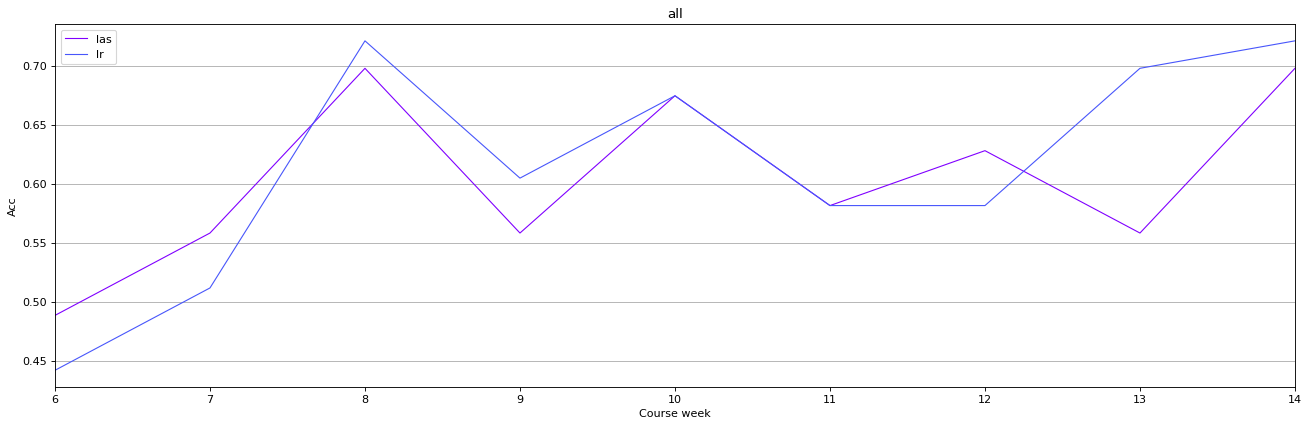

In [259]:
plot_metrics_per_feature(df_results, weeks, 'Acc', 'all')

## Coefficient analysis

### Density by paper

In [228]:
nb_students, nb_features = all_featureSets['all'][6].shape

coef_abs_sum = np.zeros(nb_features)
coef_sum = np.zeros(nb_features)
for windex, wid in enumerate(weeks):
    weekly_coefs = trainedModels['all'][wid]['las'][0].best_estimator_.coef_[0]
    coef_abs_sum += np.abs(weekly_coefs)
    coef_sum += weekly_coefs

In [229]:
akpinar = AkpinarEtAl()
boroujeni = BoroujeniEtAl()
chen_cui = ChenCui()
he = HeEtAl()
lalle_conati = LalleConati()
lemay_doleck = LemayDoleck()

KeyboardInterrupt: 

In [230]:
akpinar.getNbFeatures()

4100

In [231]:
papers = [akpinar, boroujeni, chen_cui, he, lalle_conati, lemay_doleck]
paper_names = list(map(lambda x: x.__class__.__name__, papers))

In [232]:
paper_partition = [0]
abs_sum = []
prop = []
last_idx = 0

for paper in papers:
    nb_features = paper.getNbFeatures()
    paper_partition.append(last_idx + nb_features)
    paper_coefs = coef_abs_sum[last_idx: last_idx + nb_features].sum()
    abs_sum.append(paper_coefs)
    prop.append(paper_coefs / nb_features)
    last_idx += nb_features

pd.DataFrame(data = [abs_sum, prop], columns= paper_names, index=['Absolute sum of coefficients', 'Coef contribution over nb of features'])

,AkpinarEtAl,BoroujeniEtAl,ChenCui,HeEtAl,LalleConati,LemayDoleck
Absolute sum of coefficients,1188.709781,37.256540,25.126593,11.341359,81.265705,31.727523
Coef contribution over nb of features,0.289929,3.104712,2.284236,3.780453,3.869795,3.172752


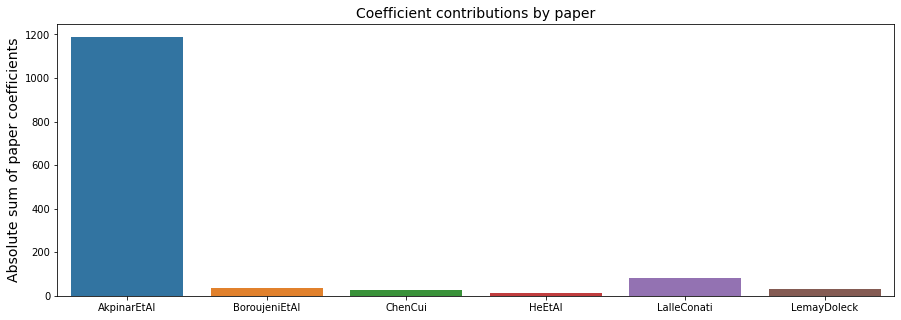

In [233]:
plt.figure(figsize=(15,5))
plt.title("Coefficient contributions by paper", fontSize=14)
plt.ylabel("Absolute sum of paper coefficients", fontSize=14)
sns.barplot(x=paper_names, y=abs_sum);

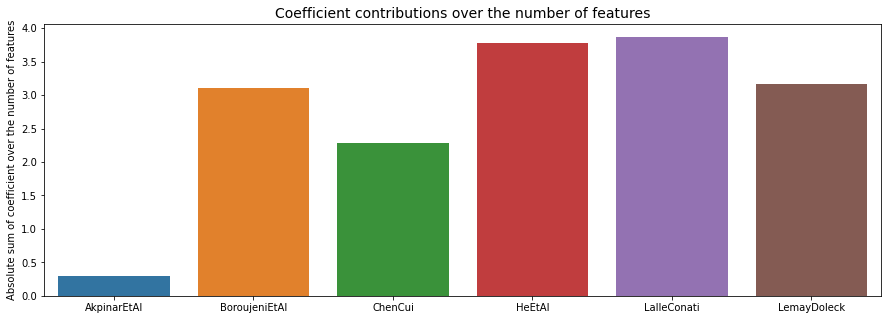

In [234]:
plt.figure(figsize=(15,5))
plt.title("Coefficient contributions over the number of features", fontSize=14)
plt.ylabel("Absolute sum of coefficient over the number of features")
sns.barplot(x=paper_names, y=prop);

### Best coefficients

Let's find which coefficients has the most contributions among all the features.

In [38]:
nb_best_coef = 10 #Number of coefficient we want

#Select the specified coef
best_idx = (-coef_abs_sum).argsort()
top_idx = best_idx[:nb_best_coef]
top_coef = coef_abs_sum[top_idx]
top_mean_coef = coef_sum[top_idx] / nb_students

In [39]:
#Associate each coef with the corresponding paper and feature
paper_attribution = np.digitize(top_idx, paper_partition)
paper_feature_idx = []
for i, coef_idx in enumerate(top_idx):
        paper_feature_idx.append(coef_idx - paper_partition[paper_attribution[i] - 1])
        
best_coef_paper = np.array(papers)[paper_attribution - 1]
best_coef_paper_names = np.array(paper_names)[paper_attribution - 1]
couple_paper_idx = list(zip( best_coef_paper, best_coef_paper_names, paper_feature_idx))

In [40]:
#Display values
feat_array = []
for i, (paper, paper_name,feat_idx) in enumerate(couple_paper_idx):
    feat_array.append([paper.getFeatureNames()[feat_idx], paper_name, top_coef[i], top_mean_coef[i]])
pd.DataFrame(data=feat_array, columns=['Feature','Paper', 'Absolute coef sum', 'Mean value']).set_index("Feature")

,Paper,Absolute coef sum,Mean value
Feature,,,
avgWeeklyPropReplayed,LalleConati,15.617391,-0.072978
"(Video.Play, Video.Load, Video.Seek)",AkpinarEtAl,14.416458,0.067367
"(Problem.Graded, Problem.Check, Problem.Reset)",AkpinarEtAl,14.078774,0.065789
"(Video.Pause, Video.Pause, Problem.Reset)",AkpinarEtAl,13.959073,0.065229
"(Problem.Check, Problem.Graded, Problem.Reset)",AkpinarEtAl,13.029472,0.050059
"(Video.Play, Video.Play, Problem.Check)",AkpinarEtAl,11.820441,-0.055236
stdWeeklyPropReplayed,LalleConati,11.696945,-0.054659
"(Video.Load, Video.Load, Video.Load)",AkpinarEtAl,11.555708,0.048676
attendanceVideos,AkpinarEtAl,11.511359,0.049599
